In [ ]:
import itertools
import os
import sys

import cv2
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import warnings

from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from PIL import Image
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy import signal
from scipy import stats as st
from skimage import (
    io,
    filters,
    segmentation,
    )

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from sklearn.neighbors import KernelDensity
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from skimage.segmentation import felzenszwalb, mark_boundaries, quickshift, slic, watershed


warnings.simplefilter("ignore")


## Visualize Original and Gaussian Filtered Images

In [ ]:
img = plt.imread("../unsegmented/000.tif")
img_tws = plt.imread("../segmented/000.tif")
img_tws2 = np.asarray(Image.open("../segmented/000.tif")).reshape(501, 501)
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img, cmap='gray')
rect0 = patches.Rectangle((0, 0), 501, 250, edgecolor='w', fill=False)
rect1 = patches.Rectangle((0, 0), 501, 250, edgecolor='w', fill=False)
rect2 = patches.Rectangle((0, 0), 250, 501, edgecolor='w', fill=False)
rect3 = patches.Rectangle((0, 0), 250, 501, edgecolor='w', fill=False)
scalebar0 = AnchoredSizeBar(ax[0].transData,
                           100, r'4.55 $\mu$m', 'lower center', 
                           pad=0.1,
                           color='red',
                           frameon=False,
                           size_vertical=1
                           )
scalebar1 = AnchoredSizeBar(ax[1].transData,
                           100, r'4.55 $\mu$m', 'lower center', 
                           pad=0.1,
                           color='red',
                           frameon=False,
                           size_vertical=1
                           )

ax[0].add_artist(scalebar0)
ax[0].add_patch(rect0)
ax[0].add_patch(rect2)
ax[0].set_title("Original")
# ax[0].axes.get_xaxis().set_visible(False)
# ax[0].axes.get_yaxis().set_visible(False)

ax[1].imshow(img_tws, cmap='gray')
ax[1].add_patch(rect1)
ax[1].add_patch(rect3)
ax[1].add_artist(scalebar1)
ax[1].set_title("TWS Segmented")
# ax[1].axes.get_xaxis().set_visible(False)
# ax[1].axes.get_yaxis().set_visible(False)
plt.savefig("../figures/tws-segmented.png", dpi=500, pad_inches=0);
plt.tight_layout();
# plt.show()

In [ ]:
def neighborhood_mean(img, nx, ny):
    """
    Replace value with average of nx voxels in the +x direction and ny voxels in the +y direction for total a
    """
    img_out = np.zeros(img.shape)
    Nx, Ny = img.shape
    for i in range(Nx):
        for j in range(Ny):
            x = Nx - 1
            if i + nx < Nx:
                x = i + nx
            y = Ny - 1
            if j + ny < Ny:
                y = j + ny
            if np.isnan(np.nanmean(img[i:x, j:y])):
                # print(i, j)
                # print(np.nanmean(img[i:x, j:y]))
                img_out[i, j] = img[i, j]
            else:
                img_out[i, j] = np.nanmean(img[i:x, j:y])
    
    return img_out


def standardize_image(img, nx, ny):
    """
    Replace value with average of nx voxels in the +x direction and ny voxels in the +y direction for total a
    """
    img_out = np.zeros(img.shape)
    Nx, Ny = img.shape
    for i in range(Nx):
        for j in range(Ny):
            x = Nx - 1
            if i + nx < Nx:
                x = i + nx
            y = Ny - 1
            if j + ny < Ny:
                y = j + ny
            if np.isnan(np.nanmean(img[i:x, j:y])):
                # print(i, j)
                # print(np.nanmean(img[i:x, j:y]))
                # img_out[i, j] = img[i, j]
                pass
            else:
                img_out[i, j] = (img[i, j] - np.mean(img[i:x, j:y])) / np.std(img[i:x, j:y])
    
    return img_out

In [ ]:
# for f in sorted(os.listdir("../unsegmented")):
#     print(f)
#     if not f.endswith(".tif"):
#         continue
#     img1 = cv2.imread(f"../unsegmented/{f}", cv2.IMREAD_UNCHANGED)
#     img2 = neighborhood_mean(img1, 5, 10)
#     cv2.imwrite(f"../averaged-unsegmented/{f.strip('.tif')}.png", img2)

# Features Matrix

In [272]:
# segments_slic = slic(img, n_segments=50, compactness=0.0001, sigma=10,
#                      start_label=1)
# img = plt.imread("../FIB-SEM/SEM Image - SliceImage - 001.tif")
img2 = cv2.imread("../unsegmented/000.tif", cv2.IMREAD_UNCHANGED)
img3 = neighborhood_mean(img2, 10, 10)
img3 = neighborhood_mean(img3, 5, 5)
img3 = neighborhood_mean(img3, 5, 5)
img3 = neighborhood_mean(img3, 5, 5)
# img3 = standardize_image(img2, 10, 10)
max_pix = np.max(img3)
img = img3 / max_pix
phases = {
    "lower_am": [0.55, 1.0],
    "lower_am_b": [0.45, 0.55],
    "lower_am_c": [0.4, 0.45],
    "se_a": [0.35, 0.4],
    "se_b": [0.325, 0.35],
    "se_c": [0.3, 0.325],
    "se_d": [0.25, 0.3],
    "se_e": [0.2, 0.25],
}
coords = np.argwhere(np.logical_and(np.greater(img, 0.325), np.less_equal(img, 0.4)))
y = np.array([img[tuple(coords[i])] for i in range(coords.shape[0])]).reshape(-1, 1)
X = np.hstack((coords / (img.shape[0] - 1), y))
pca = PCA()
X_pca = pca.fit_transform(X)

# Agglomerative Clustering

In [ ]:
max_d = 10
k = 4
Z = linkage(X, method='single')
y_predict = fcluster(Z, max_d, criterion = 'distance')

# Gaussian Mixture

In [ ]:
n = 10
gmm = GaussianMixture(n_components=n, covariance_type="full")
y_predict = gmm.fit_predict(X_pca)
probs = gmm.predict_proba(X_pca)

# Bayesian Gaussian Mixture

In [273]:
n = 10
bgm = BayesianGaussianMixture(n_components=n, weight_concentration_prior_type='dirichlet_distribution', warm_start=True).fit(X)
y_predict = bgm.predict(X)

# Kernel Density Estimation

In [ ]:
kde_1d = KernelDensity(kernel='gaussian', bandwidth=0.2)
kde_1d.fit(X)
y_predict = kde_1d.sample(X.shape[0])[:, 2]

# DBSCAN

In [ ]:
eps = 1
min_samples = 5
db = DBSCAN(eps=eps, min_samples=min_samples)
db.fit(X)
y_predict = db.fit_predict(X).reshape(-1, 1)

# Clustering Results

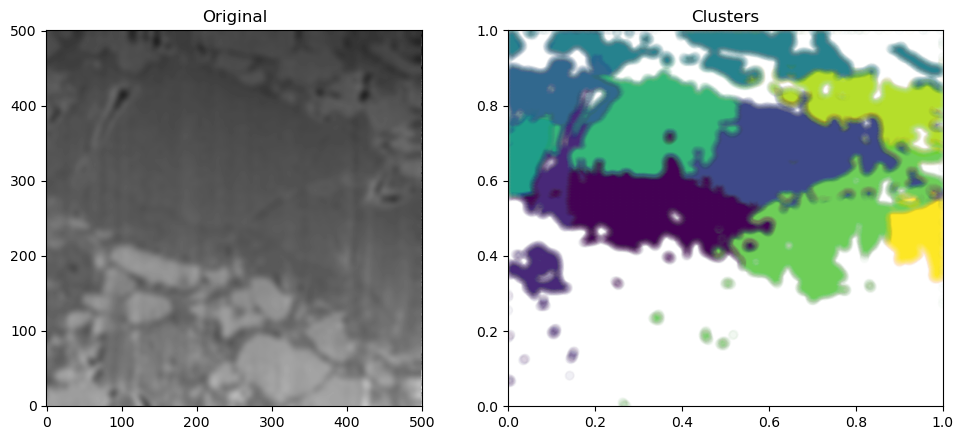

In [274]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
ax[0].imshow(img, cmap='gray')
ax[0].invert_yaxis();
ax[1].scatter(X[:, 1], X[:, 0], c=y_predict, alpha=0.01)
ax[0].set_title('Original');
ax[1].set_title(f"Clusters");
ax[1].invert_yaxis();
ax[1].set_xlim([0, 1]);
ax[1].set_ylim([0, 1]);
plt.tight_layout();

plot_clusters = False
if plot_clusters:
    for i in range(n):
        coords = np.argwhere(y_predict == i)
        fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))
        ax[0].imshow(img, cmap='gray')
        ax[0].invert_yaxis();
        ax[1].scatter(X[coords, 1], X[coords, 0], alpha=0.05)
        ax[0].set_title('Original');
        ax[1].set_title(f"Clusters");
        ax[1].invert_yaxis();
        ax[1].set_xlim([0, 1]);
        ax[1].set_ylim([0, 1]);
        plt.tight_layout();

In [ ]:
img2 = cv2.imread("../unsegmented/000.tif", cv2.IMREAD_UNCHANGED)
img = standardize_image(img2, 10, 10)
fig, ax = plt.subplots()
ax.hist(img.ravel(), bins=10, density=True);

In [ ]:
def show_image(digit_data, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 5))
    print(len(digit_data))
    img_ = digit_data.reshape(501, 501)
    ax.imshow(img_, cmap = 'binary')

n_components = np.arange(1, 31)


k = 501
pca_model = PCA(n_components=k)
pca_model.fit(img)
X_k = pca_model.transform(img)

BICs = []
models = []
for n in n_components:
    gmm_n =  GaussianMixture(n, covariance_type='full').fit(X_k)
    bic = gmm_n.bic(img)
    BICs.append(bic)
    models.append(gmm_n)

fig, ax = plt.subplots()
ax.plot(n_components, BICs)
ax.set_xlabel('# of Components', size=18);
ax.set_ylabel('BIC', size=18)
ax.set_xticks(n_components);
plt.tight_layout();

In [ ]:
gmm_n =  models[4]
bic = gmm_n.bic(img)
example = gmm_n.sample()
show_image(example)

The top left corner of the white rectangle section of TWS segmented image should be green to indicate electrolyte phase.
Overall, the sections highlighted in white show that the segmentation deems active material particles to be fused when they are not fused in the original image. This fusion underestimates specific active material area.

In [ ]:
img_gauss = filters.gaussian(img)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_gauss, cmap='gray')
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_title("Gaussian Filter")

plt.show()

### FFT Band Pass Filter

In [ ]:
def H_lo(D, D0, n):
    return 1 / (1 + (D/D0) ** (2 * n))


def H_hi(D, D0, n):
    return 1 / (1 + (D0/D) ** (2 * n))

def fft_denoise(img, band_type='lo'):
    """"""
    if band_type not in ('lo', 'hi'):
        raise ValueError("Unknown band type")
    F = np.fft.fft2(img)
    Fshift = np.fft.fftshift(F)
    M, N = img.shape
    H = np.zeros((M, N), dtype=np.float32)
    n = 1
    D0 = 0.75

    for u in range(M):
        for v in range(N):
            D = np.sqrt((u - M/2) ** 2 + (v - N/2) ** 2)
            if band_type == 'hi':
                H[u, v] = H_hi(D, D0, n)
            else:
                H[u, v] = H_lo(D, D0, n)

    Gshift = Fshift * H
    G = np.fft.ifftshift(Gshift)
    g = np.abs(np.fft.ifft2(G)) * 255
    
    return g

g = fft_denoise(img_gauss, 'hi')
D0 = 0.75
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(img, cmap="gray")
rect = patches.Rectangle((150, 350), 50, 50, edgecolor='r', fill=False)
ax[0].add_patch(rect)
ax[0].set_title("Original")
ax[1].imshow(g, cmap="gray")
rect1 = patches.Rectangle((150, 350), 50, 50, edgecolor='r', fill=False)
ax[1].add_patch(rect1)
ax[1].set_title(f"Filtered, cut off freq = {D0}")
plt.imsave("../figures/fft-hi-unsegmented.bmp", g, cmap='gray', format="bmp")
plt.show()

In [ ]:
thresholds = filters.threshold_multiotsu(g)
img_seg = np.digitize(g, bins=thresholds)
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_seg, cmap='gray')
plt.show()

## Segmentation via Edge Detection
We could try different thresholds with the Meijering filter and then identify clusters for each threshold. For each threshold, we calculate the pixel average per cluster. The best threshold is the on that minimizes the variance of the pixel average per cluster<br/>
### Meijering Filter

In [ ]:
img_meijer = filters.meijering(g) #< 0.1
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
rect = patches.Rectangle((200, 50), 200, 200, edgecolor='r', fill=False)
ax[0].imshow(img, cmap='gray')
ax[0].add_patch(rect)
ax[0].set_title("Unsegmented")
ax[1].axes.get_xaxis().set_visible(False)
ax[1].axes.get_yaxis().set_visible(False)
ax[1].imshow(img_meijer, cmap='gray')
ax[1].axes.get_xaxis().set_visible(False)
ax[1].axes.get_yaxis().set_visible(False)
ax[1].set_title("Meijering Filter w/ Threshold")
rect = patches.Rectangle((200, 50), 200, 200, edgecolor='r', fill=False)
ax[1].add_patch(rect)
# plt.savefig("../figures/img-meijer-threshold.png", dpi=500)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(img[200:400, 50:250], cmap='gray')
ax[0].axes.get_xaxis().set_visible(False)
ax[0].axes.get_yaxis().set_visible(False)

ax[1].imshow(img_meijer[200:400, 50:250], cmap='gray')
ax[1].axes.get_xaxis().set_visible(False)
ax[1].axes.get_yaxis().set_visible(False)

plt.show()

### Identification of Clusters

In [ ]:
points = set()
for (x, y) in np.argwhere(img_meijer):
    points.add((x, y))
point_ids = np.zeros((len(points), 2))
for idx, point in enumerate(points):
    point_ids[idx, :] = point
points_view = {(v[0], int(v[1])): k for k, v in enumerate(point_ids)}

G = nx.Graph()
for k, v in points_view.items():
    G.add_node(v)
for k in points_view.keys():
    x, y = k
    neighbors = [
        (int(x + 1), y),
        (int(x - 1), y),
        (x, int(y + 1)),
        (x, int(y - 1)),
        (int(x + 1), int(y + 1)),
    ]
    p0 = points_view[k]
    for neighbor in neighbors:
        p = points_view.get(neighbor)
        if p is None:
            continue
        G.add_edge(p0, p)
pieces = nx.connected_components(G)
pieces = [piece for piece in pieces]

### Average of pixel values per connected pixels cluster

In [ ]:
pixel_average = np.zeros(len(pieces)).reshape(-1, 1)
for idx, piece in enumerate(pieces):
#     if len(piece) < 50:
#         continue
    piece_points = np.array([point_ids[p] for p in piece], dtype=np.int32)
    pixel_average[idx] = np.average(img_meijer[piece_points])

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(range(len(pieces)), sorted(pixel_average.tolist(), reverse=True), '.k')
ax.set_xlabel("piece id")
ax.set_ylabel("pixel average")
plt.show()

In [ ]:
clusters = np.zeros(img.shape)
cluster_points = set()
for idx, piece in enumerate(pieces):
    piece_points = np.array([point_ids[p] for p in piece], dtype=np.int32)
    avg = np.std(img_gauss[piece_points])
    clusters[piece_points] = avg

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(clusters, cmap='gray')
ax.set_title("Clusters from Edge Detection -- Shows FIB-SEM Milling Lines?")
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
plt.show()

## Image Blurring

In [ ]:
img_blur = cv2.blur(img_meijer.astype(np.uint8), (5,5)) * 255
fig, ax = plt.subplots()
ax.imshow(img_blur, cmap='gray')

ax.set_title("Blurred Post Meijer")
rect = patches.Rectangle((150, 350), 5, 5, edgecolor='r', fill=False)
ax.add_patch(rect)

plt.show()

## Canny Edge Detection

In [ ]:
edges = np.asarray(cv2.Canny(image=img_blur, threshold1=100, threshold2=200)) / 255
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(edges, cmap='gray')

ax.set_title("Canny Filter")
rect = patches.Rectangle((150, 350), 50, 50, edgecolor='r', fill=False)
ax.add_patch(rect)

plt.show()

In [ ]:
print(np.average(edges[150:200, 350:400]))
plt.imshow(edges[150:200, 350:400], cmap='gray')
plt.show()

## Segmentation

In [ ]:
img_seg = np.digitize(img, bins=[30, 60])
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(img_seg, cmap='gray')
plt.show()

In [ ]:
g = img_gauss
for i in range(2):
    g = cv2.blur(g, (5,5))
    g = fft_denoise(g, 'hi')

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(g, cmap='gray')
plt.show()